In [1]:
%pylab inline 
import networkx as nx
from numpy import *
from scipy.linalg import block_diag
from scipy import sparse
import matplotlib.colors as colors
import pylab
import sys
import string
import pandas as pd


import gudhi as gd


sys.path.append('../code')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from MMC_util import *
from MMC_plot_util import *
from NNO_util_minh import *

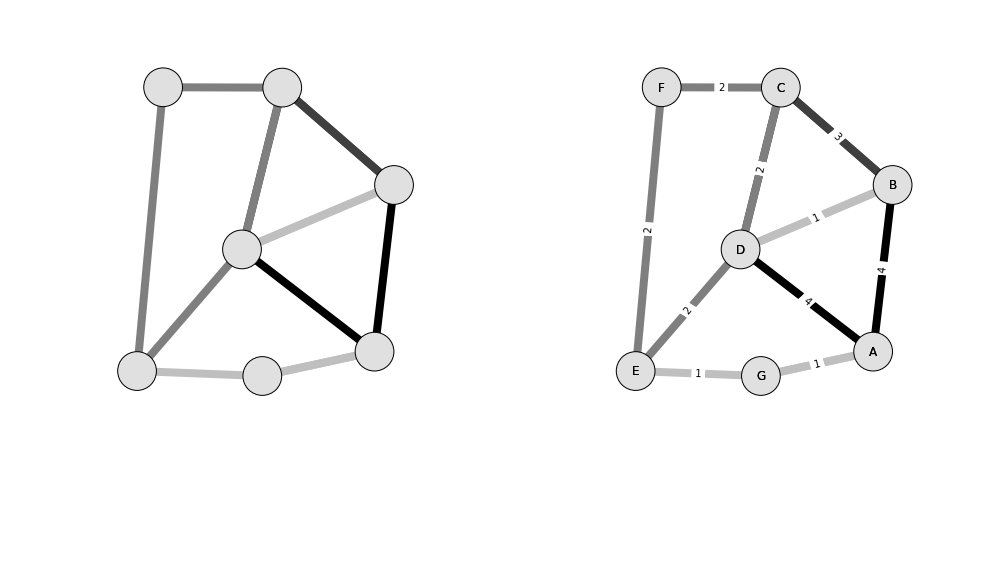

In [3]:
G = make_toy_graph()
node_colors = 3.5*np.ones(len(list(G.nodes))) #list(np.random.rand(len(list(G.nodes()))))
A = np.array((nx.adjacency_matrix(G)).todense())

m = get_edge_colors(A,A)
edge_colors = m
#node_cmap = plt.cm.gray
node_cmap = plt.cm.gray
edge_cmap = plt.cm.gray.reversed()
s = edge_cmap
node_size = 1500
edge_width = 8
vmin = 0
vmax = 4

T=2
fig, ax = plt.subplots(1,T,figsize=(14,8))
for i in range(T):
    #fig1,ax = plt.subplots(1,1,figsize=(2.5,2.5))
    draw_toy_undirected_graph(G,vmin,vmax,node_size,node_colors,edge_colors,edge_width,node_cmap,edge_cmap,s,ax[i])
plt.tight_layout()
savefig('undirected.pdf')

In [4]:
def draw_toy_graph(G,vmin,vmax,node_size,node_colors,edge_colors,edge_width,node_cmap,edge_cmap,s,ax,color_title=''):
   
    pos = nx.get_node_attributes(G,'pos')
    #vmin=0#min(edge_colors)
    #vmax=1#max(edge_colors)

    
    nodes_draw = nx.draw_networkx_nodes(G,
                       pos=pos, 
                       node_color = node_colors, 
                       node_size=node_size,
                       cmap=node_cmap,
                       vmin=vmin,
                       alpha=1,
                       vmax=vmax,
                       label=list(G.nodes()),
                       ax=ax)
    nodes_draw.set_edgecolor('k')

    edges_draw = nx.draw_networkx_edges(G,
                       pos=pos, 
                       edge_color=edge_colors,
                       edge_cmap=edge_cmap,
                       edge_vmin=vmin,
                       edge_vmax=vmax,
                       node_size=node_size,
                       ax=ax,
                       width=edge_width,
                       alpha=1,
                       arrows=True,
                       arrowsize=20)

    edge_labels = dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
    edgelabels_draw = nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    nodeslabels_draw = nx.draw_networkx_labels(G,pos)
    #fig1.tight_layout(nodes_draw)
    ax.axis('off')
    #ax.set_xlim([-1,1])
    #ax.set_ylim([-2,1])
    # make colorbar
    sm = plt.cm.ScalarMappable(cmap=s, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm,label=color_title)
    
    return 

def get_pageRank_net_flow(A,alpha):
    p_rank = pagerank (A,alpha)
    P = google_matrix (A,alpha)
    F =  np.dot(np.diag(p_rank),P) # net flows over edges
    return F

def get_edge_colors(A,matrix):
        C = (np.array(np.where(A)))[0]
        D = (np.array(np.where(A)))[1]
        m = np.zeros(len(C))
        for t in range(len(C)):
            m[t] = matrix[C[t],D[t]]
    
        return m
    
def get_filtration_matrix(XX,max_value=.1,numsteps=8):
    
    #symmetrize input matrix
    m,n = shape(XX)
    XX = max_matrix(XX,m,n)
    
    #filtration_matrix = (XX==0)*np.max(XX)*10 + XX #make non-edges some huge number
    filtration_matrix = (XX==0)*max_value + XX #make non-edges some huge number
    filtration_matrix = filtration_matrix  - np.diag(np.diag(filtration_matrix))
    return filtration_matrix, np.linspace(0,np.max(XX),numsteps)

def get_weighted_filtration(G, # original graph
                            filtration_matrix,#matrix to filter 
                            filtration_steps):#steps for filtering

    labels = list(G.nodes())#node names
    
    GG = G
    filtration=[]
    for k,step in enumerate(filtration_steps):
        AA = np.array( filtration_matrix <= step,int)
        for i in range(len(AA)):
            AA[i,i] = 0
        A2 = pd.DataFrame(AA, index=labels, columns=labels)    
        GG = nx.to_networkx_graph(A2)
        #mapping = dict(zip(GG, string.ascii_lowercase))
        #GG = nx.relabel_nodes(G, mapping)  # nodes are characters a through z
        filtration.append(GG)
    return filtration

 
def make_wfiltration_fig(G,nets,titles,y_label):
    
    pos = nx.get_node_attributes(G,'pos')
    
    fig, ax = plt.subplots(1,len(nets),figsize=(6,1.5))
#    ax = axes.flatten()

    for i in range(len(nets)):
        nx.draw_networkx(nets[i], 
                         pos=pos,
                         ax=ax[i], 
                         node_size=20,
                         font_size=1,
                         node_color='k')  
        ax[i].set_title(titles[i], fontsize=8)
        ax[i].set_xlim([-1,1])
        ax[i].set_ylim([-1.5,1])        
        ax[i].axis('off')
        if i==0:
             ax[i].set_ylabel(y_label)
#    plt.show()
    plt.tight_layout();
    #savefig('VR_filtration.pdf');
    return fig,ax






In [5]:
AA =  max_matrix(A,np.shape(A)[0],np.shape(A)[1])


In [6]:
def get_filtration_matrix_3(XX,max_value=.1,numsteps=8):
    
    #symmetrize input matrix
    m,n = shape(XX)
    XX = max_matrix(XX,m,n)
    
    fil_matrix = max_value - XX
    fil_matrix = fil_matrix - np.diag(np.diag(fil_matrix))
    
    return fil_matrix, max_value - np.linspace(.18,max_value*.92,numsteps)


In [7]:
def max_matrix(M,m,n):
    K=np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            K[i][j]=max(M[i][j],M[j][i])
    return (K)


In [8]:
max_value=np.max(A)*1.1
filtration_matrix,filtration_steps = get_filtration_matrix_3(A,max_value=max_value,numsteps=6)
filtration_steps = array([round(s,4) for s in filtration_steps])
filtration = get_weighted_filtration (G,filtration_matrix,max_value-filtration_steps)


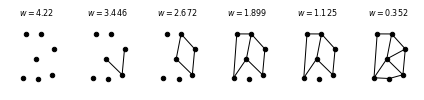

In [9]:
VR_titles = ['$w = '+str(filtration_steps[i])[:5]+'$' for i in range(len(filtration_steps))]
make_wfiltration_fig(G,filtration,VR_titles,'')
plt.tight_layout()


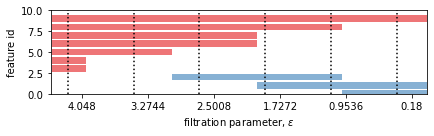

In [10]:
diag = dist2PD (filtration_matrix, max_dim=2, max_edge_length=5)[1]


f1,ax = subplots(1,1,figsize=(6,2))       
gd.plot_persistence_barcode (persistence=diag,axes=ax)

for i,step in enumerate(max_value - filtration_steps):
    plt.plot([step,step],[0,10],'k:')

#x = [.0,.01,.02,.03,.04,.05,.06]
#values = [round(max_value-xx,4) for xx in x]
values = [ round(max_value-xx,4)  for xx in filtration_steps]

plt.xlim([-.02,max_value])
plt.xticks (filtration_steps,values)
plt.ylabel('feature id')
plt.xlabel('filtration parameter, $\epsilon$')

max_value

plt.title('')
plt.tight_layout()
